# ISMIR 2018 Tutorial
# Deep Learning for Music Information Retrieval

## Part 1: Convoluational Neural Networks for Instrumental, Genre and Mood Detection in Music

Author: Thomas Lidy

This tutorial shows how different Convolutional Neural Network architectures are used for:
* Instrumental vs. Vocal Detection:  detecting whether a piece of music is instrumental or contains vocals
* Genre Classification
* Mood Recognition

The data set used is the [MagnaTagATune Dataset](http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset), but a smaller subset of it, with only 1 sample excerpt of each of the original audio files.

It consists of 5405 files, each 30 seconds long. 

The annotations for this dataset contain a multitude of tags, including some that hint at whether the file is instrumental or vocal.

### Table of Contents

This tutorial contains:
* Loading and Preprocessing of Audio files
* Loading class files from CSV and using Label Encoder
* Audio Preprocessing: Generating log Mel spectrograms
* Standardization of Data
* Convolutional Neural Networks
* Train/Test set split

* Instrumental vs. Vocal Detection
* Genre Classification
* Mood Recognition

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

### Requirements

* Python >= 3.5
* Keras >= 2.1.1
* Tensorflow
* scikit-learn >= 0.18
* Pandas
* Librosa
* MatplotLib

### Download Data

If you haven't already (follwing [README](../README.md#download-prepared-datasets)), 
please download the following data sets for this tutorial:

#### MagnaTagAtune

Prepared Spectrograms: https://owncloud.tuwien.ac.at/index.php/s/VyDlQKmsA2EFAhv (209MB)

Unzip them into a folder, e.g. inside this Tutorial folder, and adapt the following `DATA_PATH` variable:

In [8]:
# SET PATH OF DOWNLOADED DATA HERE
# '.' is ok if you unzipped the files inside this tutorials folder

METADATA_PATH = 'metadata'
DATA_PATH = './ISMIR2018_tut_prepared_features'

from os.path import join
SPECTROGRAM_FILE = join(DATA_PATH, 'ISMIR2018_tut_Magnagtagatune_spectrograms.npz')

In [9]:
# IF YOU USE A GPU, you may set which GPU(s) to use here:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2" #"0,1,2,3" 

In [10]:
# General Imports

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation

# Deep Learning

import keras
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

# Machine Learning preprocessing and evaluation

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
# local imports for audio reading and processing
#import audio_spectrogram as rp
#from audiofile_read import audiofile_read

## Load the Metadata

The tab-separated file contains pairs of filename TAB class.

In [13]:
csv_file = os.path.join(METADATA_PATH,'annotations_final_subsample.csv')

# we select the last column (-1) as the index column (= filename)
metadata = pd.read_csv(csv_file, index_col=0, sep='\t')

metadata.shape

(3023, 189)

In [14]:
metadata.head()

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
mp3_path,,,,,,,,,,,,,,,,,,,,,
d/ambient_teknology-the_all_seeing_eye_project-01-cyclops-262-291.mp3,1119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-02-all_seeing_eye-175-204.mp3,6021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-03-black-175-204.mp3,11847,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-04-confusion_says-88-117.mp3,17119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d/ambient_teknology-the_all_seeing_eye_project-05-the_beholder-291-320.mp3,25118,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# we make the clip_id the index and drop the orignal mp3_path
# as we later align by clip_id

metadata.set_index('clip_id', inplace=True)
metadata.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
clip_id,,,,,,,,,,,,,,,,,,,,,
1119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1) Instrumental vs. Vocal Detection

this is a binary classification task (output decision is between 0 and 1)

### Create 2 classes from a list of tags

There are plenty of "tags" in this data set which hint at wether a track is "vocal" or "instrumental". We group these tags and finally come up with 1 boolean column saying whether a track is "vocal" or "instrumental".

In [ ]:
tags_vocal = ['singer', 'female singing', 'female opera', 'male vocal', 'vocals', 'men', 'female', 'female voice', 'voice', 'male voice', 'girl', 'chanting', 'talking', 'choral', 'male singer', 'man singing', 'male opera', 'chant', 'man', 'female vocal', 'male vocals', 'vocal', 'woman', 'woman singing', 'singing', 'female vocals', 'voices', 'choir', 'female singer', 'women', 'choir', 'women']

tags_instrumental = ['instrumental', 'no voice', 'no voices', 'no vocals', 'no vocal', 'no singing', 'no singer']

In [ ]:
metadata[tags_vocal].head()

In [ ]:
# set vocal to True of any of the tags_vocal are 1
gt_vocal = metadata[tags_vocal].any(axis=1)
gt_vocal.head()

In [ ]:
# set instrumental to True of any of the tags_instrumental are 1
gt_instrumental = metadata[tags_instrumental].any(axis=1)
gt_instrumental.head()

<b>We can only use the tag if EITHER instrumental OR vocal is True.</b><br>
If both of them are True or both of them are False, we cannot trust the groundtruth data. Ergo we have to remove these and retain only the others.

In [ ]:
retain = np.logical_xor(gt_vocal,gt_instrumental)
retain.head()

In [ ]:
n_orig = len(gt_vocal)
n_retain = sum(retain)

print("For instrumental vs. vocal, from originally", n_orig, "input examples, we can only retain",n_retain, "trusted ones in our groundtruth")

In the end we cut from gt_vocal only the instances to retain. If they are True they are vocal, if they are False, they are instrumental:

In [ ]:
gt_final = gt_vocal[retain]
gt_final.head(9)

In [ ]:
print(str(sum(gt_final)) + " vocal tracks")

In [ ]:
print(str(sum(np.logical_not(gt_final))) + " instrumental tracks")

<b>Create two lists: one with the clip_ids and one with associated classes</b>

In [ ]:
# index in list of clip_ids
clip_ids = gt_final.index.tolist()
# convert boolean to int and store in other list
classes = (gt_final * 1).tolist()

In [ ]:
clip_ids[0:5]

In [ ]:
classes[0:5]

In [ ]:
# convert to Numpy array as needed by Keras
classes = np.array(classes)
classes[0:5]

## Load Audio Spectrograms

We have pre-processed the audio files already and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids.

In [16]:
with np.load(SPECTROGRAM_FILE) as npz:
    spectrograms = npz["features"]
    spec_clip_ids = npz["clip_id"]
    
spectrograms.shape

(6380, 80, 80)

In [17]:
len(spec_clip_ids)

6380

In [18]:
# create dataframe that associates the order of the spectrograms with the clip_ids
spectrograms_clip_ids = pd.DataFrame({"spec_id": np.arange(spectrograms.shape[0])}, index = spec_clip_ids)
spectrograms_clip_ids.head()

,spec_id
66,0
90,1
91,2
94,3
105,4


### Show Mel Spectrogram (1 example just for illustration)

In [19]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

In [20]:
# take first spectrogram as an example
spec = spectrograms[0]

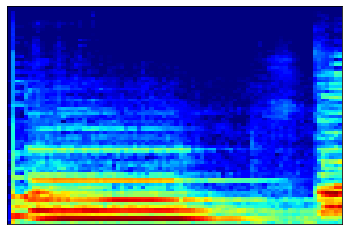

In [21]:
# plot it 
fig = plt.imshow(spec, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

We use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
Here, we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribut-wise standardization in our experiments).

We use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first.

In [22]:
def standardize(data):
    # vectorize before standardization (cause scaler can't do it in that format)
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim)

In [23]:
spectrograms = standardize(spectrograms)
spectrograms.shape

## Align Metadata and Spectrograms

#### 1) Resolve numeric ids in *labels.csv files to clip ids from Magnatagatune set

In [24]:
metadata_genre = pd.read_csv(join(METADATA_PATH, "ismir2018_tut_part_2_genre_labels.csv"), index_col=0)
metadata_genre.shape

(2617, 7)

In [25]:
metadata_genre_clip_ids = pd.read_csv(join(METADATA_PATH, "ismir2018_tut_part_2_genre_metadata.csv"), index_col=0)
metadata_genre_clip_ids.shape

(2617, 10)

In [26]:
metadata_genre_clip_ids.head()

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
15066,32957,D:/Research/Data/MIR/MagnaTagATune/mp3_full/7/...,7,Reckless Woman Blues,Jag,Cypress Grove Blues,http://www.magnatune.com/artists/albums/jag-cy...,117,146,http://he3.magnatune.com/all/07-Reckless%20Wom...
5256,11455,D:/Research/Data/MIR/MagnaTagATune/mp3_full/3/...,3,All Worn Out,Jag,Four Strings,http://www.magnatune.com/artists/albums/jag-four/,30,59,http://he3.magnatune.com/all/03-All%20Worn%20O...
23603,52328,D:/Research/Data/MIR/MagnaTagATune/mp3_full/3/...,14,You're Cheatin' On Me,Jag,Four Strings,http://www.magnatune.com/artists/albums/jag-four/,88,117,http://he3.magnatune.com/all/14-You're%20Cheat...
24083,53525,D:/Research/Data/MIR/MagnaTagATune/mp3_full/7/...,16,Baby Don't Say That,Jag,Cypress Grove Blues,http://www.magnatune.com/artists/albums/jag-cy...,88,117,http://he3.magnatune.com/all/16-Baby%20Don't%2...
20833,45825,D:/Research/Data/MIR/MagnaTagATune/mp3_full/4/...,11,How the story goes,Burnshee Thornside,The Art of Not Blending In,http://www.magnatune.com/artists/albums/burnsh...,146,175,http://he3.magnatune.com/all/11-How%20the%20st...


In [27]:
# replace the numeric id from metadata_genre by clip_id from metadata_genre_clip_ids

clip_ids_sorted_by_index = metadata_genre_clip_ids.loc[metadata_genre.index]['clip_id']
metadata_genre.index = clip_ids_sorted_by_index
metadata_genre.head()

,blues,classical,country,jazz,pop,rock,techno
clip_id,,,,,,,
32957,1,0,0,0,0,0,0
11455,1,0,0,0,0,0,0
52328,1,0,0,0,0,0,0
53525,1,0,0,0,0,0,0
45825,1,0,0,0,0,0,0


In [28]:
len(metadata_genre)

2617

In [29]:
# check if we found all metadata clip ids in our spectrogram data
len(set(metadata_genre.index).intersection(set(spec_clip_ids)))

2617

In [51]:
# classes needs to be a "1-hot encoded" numpy array (which our groundtruth already is! we just convert pandas to numpy)
classes = metadata_genre.values
classes

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [61]:
n_classes = metadata_genre.shape[1]

#### 2) now from the clip_id ordered like the metadata get the correct spectrogram indices

In [49]:
clip_ids_genre = metadata_genre.index
spec_indices = spectrograms_clip_ids.loc[clip_ids_genre]['spec_id']

In [50]:
spectrograms.shape

(6380, 80, 80)

#### we select a subset of the original data for the metadata of each task

In [41]:

data = spectrograms[spec_indices,:]
data.shape

(2617, 80, 80)

#### --> our X and Y used in the following training procedures are called 'data' and 'classes'

# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. RGB images typically have a 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [42]:
def add_channel(data, n_channels=1):
    # n_channels: 1 for grey-scale, 3 for RGB, but usually already present in the data
    
    N, ydim, xdim = data.shape

    if keras.backend.image_data_format() == 'channels_last':  # TENSORFLOW
        # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
        data = data.reshape(N, ydim, xdim, n_channels)
    else: # THEANO
        # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
        data = data.reshape(N, n_channels, ydim, xdim)
        
    return data

In [43]:
data = add_channel(data, n_channels=1)
data.shape

(2617, 80, 80, 1)

In [44]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Note: 
For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

In [52]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [53]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

TRAIN INDEX: [ 521 2443 1071 ...  473  205  182]
TEST INDEX: [2103 2215 1504  425  490  785  392 1534   27  765 1086 2318  156 2297
 2422 2606 2359 2080 1732  744 1825 1545  402  966  390 2109 1541 1410
   85  495  493  405  651   93  826 1608  906  463  523 1023  522 1163
  594 2096 1171  347  333 2476  566 2373 1687 1250 1500 1926 1103 1228
 2008 1801 1464 1281  991 1431 2111  650 1003 2205  489 2077 1179 1643
  987  776 1513 1092   78 2545 1699  502 1373 1782 1863 2268   28 2394
 2513 1563 1107 2286 1836 2142  873  345  884 1129 2159  141  224 2589
 1299 2236 1157 2036 1907  928 1805  259 1690 2280 1932 1000  756 2575
 1166  323  552  216 2515 2324 2407  973  528 2208   62 1639   20 2409
 2314 2566   32 1535 1542  983    9   41 2605 1772  728 2238 1363 2222
  250 2037  236  185 1517 2438  945 1788  851   68  253 2584  739 2540
 1795 2102 2038 2567  315  876  903 1453 1551 2601  221 2046 1201  127
 1420 2047 1333 2505  458  261 2149 1726 2603 1953  938 1791 1349  227
 1274 1384  916 

In [54]:
print(train_set.shape)
print(test_set.shape)

(1962, 80, 80, 1)
(655, 80, 80, 1)


In [56]:
# TODO
print("Class Counts: Class 0:", sum(train_classes==0), "Class 1:", sum(train_classes))

Class Counts: Class 0: [1940 1587 1763 1682 1626 1587 1587] Class 1: [ 22 375 199 280 336 375 375]


# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are simple concatenations of layers. Graph models can also handle those but also more complex neural network architectures. Keras now recommends to use the Graph models by default, but for a simple entry into the topic we are going to start with Sequential models first:

To try different configurations,(comment/uncomment code blockes in the following code box:
* 1 Layer
* 2 Layer
* change number of conv_filters
* Dropout

In [62]:
#np.random.seed(0) # make results repeatable

model = Sequential()

#conv_filters = 16   # number of convolution filters (= CNN depth)
conv_filters = 32   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, (3, 3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

# Layer 2
model.add(Convolution2D(conv_filters, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# After Convolution, we have a 16*x*y matrix output
# In order to feed this to a Full(Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
#model.add(Dense(1,activation='sigmoid'))
model.add(Dense(n_classes,activation='softmax'))

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2654464   
__________

## Training the CNN

In [64]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# TRAINING the model
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)### Verifying Accuracy on Test Set

Epoch 1/15
1962/1962 [==============================] - 12s 6ms/step - loss: 0.3876 - acc: 0.8573
Epoch 2/15
1962/1962 [==============================] - 12s 6ms/step - loss: 0.3510 - acc: 0.8603
Epoch 3/15
1962/1962 [==============================] - 13s 7ms/step - loss: 0.3402 - acc: 0.8682
Epoch 4/15
1962/1962 [==============================] - 12s 6ms/step - loss: 0.3326 - acc: 0.8712
Epoch 5/15
1962/1962 [==============================] - 13s 7ms/step - loss: 0.3273 - acc: 0.8735
Epoch 6/15
1962/1962 [==============================] - 12s 6ms/step - loss: 0.3222 - acc: 0.8759
Epoch 7/15
1962/1962 [==============================] - 13s 6ms/step - loss: 0.3183 - acc: 0.8759
Epoch 8/15
1962/1962 [==============================] - 14s 7ms/step - loss: 0.3147 - acc: 0.8769
Epoch 9/15
1962/1962 [==============================] - 13s 7ms/step - loss: 0.3104 - acc: 0.8777
Epoch 10/15
1962/1962 [==============================] - 12s 6ms/step - loss: 0.3070 - acc: 0.8783
Epoch 11/15
1962/19

### Verifying Accuracy on Test Set

In [ ]:
# always execute this, and then a box of accuracy_score below to print the result
test_pred = model.predict_classes(test_set)

In [ ]:
# 1 layer
accuracy_score(test_classes, test_pred)

In [ ]:
# 2 layers
accuracy_score(test_classes, test_pred)

In [ ]:
# 2 layers + 32 convolution filters
accuracy_score(test_classes, test_pred)

In [ ]:
# 2 layer + 32 convolution filters + Dropout
accuracy_score(test_classes, test_pred)

## Additional Parameters & Techniques

Try out more parameters and techniques: (comment/uncomment code blocks below)
* Adding ReLU activation
* Adding Batch normalization
* Adding Dropout

In [ ]:
model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
filter_size = (3,3)
pool_size = (2,2)

# Layer 1
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.1))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# MIREX 2015 model
model = Sequential()

conv_filters = 15   # number of convolution filters (= CNN depth)

# Layer 1
model.add(Convolution2D(conv_filters, (12, 8), padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(Activation('sigmoid')) 
model.add(MaxPooling2D(pool_size=(2, 1))) 
#model.add(Dropout(0.3))


# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(200, activation='sigmoid'))  
#model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Compiling and training the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

In [ ]:
# Verifying Accuracy on Test Set

test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

## TODO? Parallel CNNs

It has been discovered, that CNNs for music work best, when they have one filter that is detecting frequencies in the vertical axis, and nother filter that is focused on the time axis, i.e. detecting rhythm. Consequently, this is realized in a parallel CNN, where 2 layers are not stacked after each other, but first run independently in parallel with their output being merged later.

To create parallel CNNs we need a "graph-based" model. In Keras 1.x this is realized via the functional API of the Model() class.
We use it to create two CNN layers that run in parallel to each other and are merged subsequently.
In the functional API, you pass the name of the previous layer in (brackets) after defining the next layer.

In [ ]:
# TODO import from Part1a Music _speech

## Compact CNN

This is a 5 layer Convolutional Neural Network inspired and adapted from Keunwoo Choi (https://github.com/keunwoochoi/music-auto_tagging-keras)

It is specified using Keras' functional Model Graph API (https://keras.io/models/model/).

In [ ]:
data.shape

In [ ]:
def CompactCNN(input_shape, nb_conv, nb_filters, n_mels, normalize, nb_hidden, dense_units, 
               output_shape, activation, dropout, multiple_segments=False, graph_model=False, input_tensor=None):
    
    melgram_input = Input(shape=input_shape)

    if n_mels >= 256:
        poolings = [(2, 4), (4, 4), (4, 5), (2, 4), (4, 4)]
    elif n_mels >= 128:
        poolings = [(2, 4), (4, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 96:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 72:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (3, 4)]
    elif n_mels >= 64:
        poolings = [(2, 4), (2, 4), (2, 5), (2, 4), (4, 4)]

    # Determine input axis
    if keras.backend.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2
            
    # Input block
    #x = BatchNormalization(axis=time_axis, name='bn_0_freq')(melgram_input)
        
    if normalize == 'batch':
        x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)
    elif normalize in ('data_sample', 'time', 'freq', 'channel'):
        x = Normalization2D(normalize, name='nomalization')(melgram_input)
    elif normalize in ('no', 'False'):
        x = melgram_input

    # Conv block 1
    x = Convolution2D(nb_filters[0], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[0], name='pool1')(x)
        
    # Conv block 2
    x = Convolution2D(nb_filters[1], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[1], name='pool2')(x)
        
    # Conv block 3
    x = Convolution2D(nb_filters[2], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[2], name='pool3')(x)
    
    # Conv block 4
    if nb_conv > 3:        
        x = Convolution2D(nb_filters[3], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn4')(x)
        x = ELU()(x)   
        x = MaxPooling2D(pool_size=poolings[3], name='pool4')(x)
        
    # Conv block 5
    if nb_conv == 5:
        x = Convolution2D(nb_filters[4], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn5')(x)
        x = ELU()(x)
        x = MaxPooling2D(pool_size=poolings[4], name='pool5')(x)

    # Flatten the outout of the last Conv Layer
    x = Flatten()(x)
      
    if nb_hidden == 1:
        x = Dropout(dropout)(x)
        x = Dense(dense_units, activation='relu')(x)
    elif nb_hidden == 2:
        x = Dropout(dropout)(x)
        x = Dense(dense_units[0], activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(dense_units[1], activation='relu')(x) 
    else:
        raise ValueError("More than 2 hidden units not supported at the moment.")
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'output')(x)
    
    # Create model
    model = Model(melgram_input, x)
    
    return model

### Set model parameters



In [ ]:
# number of Convolutional Layers
nb_conv_layers = 4

# number of Filters in each layer
nb_filters = [64,64,64,128,128]

# number of hidden layers at the end of the model
nb_hidden = 1 # 2

# how many neurons in each hidden layer
dense_units = 128 #[128,56]

# how many output units
# IN A BINARY CLASSIFICATION TASK with 2 possible outputs, 1 single output unit is sufficent (deciding between 0 and 1)
output_shape = 1

# which activation function to use for OUTPUT layer
# IN A BINARY CLASSIFICATION TASK sigmoid activation is the right choice (activating betwee 0 and 1)
output_activation = 'sigmoid'

# which type of normalization
normalization = 'batch'

# droupout
dropout = 0.2

In [ ]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, n_mels = 96, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [ ]:
model.summary()

## Training Setup

In [ ]:
# Loss

# the loss for a binary classification task is BINARY crossentropy
loss = 'binary_crossentropy' 

In [ ]:
# Optimizers

# simple case:
# Stochastic Gradient Descent
#optimizer = 'sgd' 

# advanced:
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)#lr=0.001 decay = 0.03
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

# We use mostly ADAM
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004)

# choose
optimizer = adam

In [ ]:
# Metrics

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = ['accuracy', precision, recall]

In [ ]:
# Other
batch_size = 32 

epochs = 30

validation_split=0.1 

#n_folds = 5
random_seed = 0

callbacks = None

### Tensorboard (optional)

In [ ]:
from keras.callbacks import TensorBoard

In [ ]:
#home_dir = os.getenv("HOME")

#TB_LOGDIR = os.path.join(home_dir, "./tensorboard")

TB_LOGDIR = "./tensorboard"

experiment_name = "instrumental"

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

In [ ]:
# OPTIONAL
# new tensorboard callback at each training
# tensorboard_run_id = "Vocal_magna_2seg_adam_compact_128fbis_128h"
# tb_logdir = "%s/%s_fold%d %s" %(tb_logdir, tensorboard_run_id, fold, strftime("%Y-%m-%d %H:%M:%S", localtime()))

In [ ]:
print("Execute the following in a terminal:\n")
print("tensorboard --logdir=" + TB_LOGDIR)

In [ ]:
# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

Then open Tensorboard in browser:

http://localhost:6006

## Training

In [ ]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

In [ ]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [ ]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [ ]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

### Verifying Accuracy on Test Set

In [ ]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob[0:10]

In [ ]:
# to get the predicted class we have to round 0 < 0.5 > 1
test_pred = np.round(test_pred_prob)
test_pred[0:10]

In [ ]:
# get final Accuracy
accuracy_score(test_classes, test_pred)

# 2) Genre Classification

this is a single-label / multi-class task (multiple categories, but decision needs to be for 1 of them)

## Load Metadata

## Prepare Metadata

we start with the original metadata

In [ ]:
metadata.head()

In [ ]:
# check which columns are available
tags_all = metadata.columns.tolist()
print(tags_all)

In [ ]:
len(tags_all)

In [ ]:
genres = ['classical', 'rock', 'pop', 'jazz', 'techno'] # 'electronic', ## too little data: , 'reggae', 'metal', 'hip hop']

n_genres = len(genres)
n_genres

In [ ]:
metadata[genres]

In [ ]:
metadata[genres].sum()

In [ ]:
metadata[genres].shape

In [ ]:
# for the single-label genre task, we only retain tracks that have EXACTLY 1 genre assigned in groundtruth
idx = metadata[genres].sum(axis=1) == 1

In [ ]:
genre_metadata = metadata.loc[idx,genres]
genre_metadata.shape

In [ ]:
genre_metadata.sum()

In [ ]:
# classes needs to be a "1-hot encoded" numpy array (which our groundtruth already is! we just convert pandas to numpy)
classes = genre_metadata.values
classes

In [ ]:
filelist = genre_metadata.index.tolist()

## Load Audio Spectrograms

based on the new filelist needed for the genre task 

we keep n_mel_bands and frames the same as before

In [ ]:
# if we saved the audio spectrograms before, we try to load them
load_features = True

# if not, we store audio features for faster reload the next time
save_features = True

FEAT_FILE = os.path.join(DATA_PATH, "spectrograms_genres.npz")

In [ ]:
if load_features:
    if os.path.exists(FEAT_FILE):
        with np.load(FEAT_FILE) as npz:
            data = npz['data']
            filelist = npz['filenames']
            classes = npz['classes']
        print("Loaded features successfully: " + str(len(filelist)), "files, dimensions:", data.shape)
    else:
        load_features = False

In [ ]:
if not load_features:
    data = create_spectrograms(filelist, n_mel_bands, frames)

    if save_features:
        np.savez(FEAT_FILE, data=data, filenames=filelist, classes=classes)
        print("Features stored to " + FEAT_FILE)

In [ ]:
data.shape

In [ ]:
# standardize the data (see above)
data = standardize(data)
data.shape

In [ ]:
# add color channel (see above)
data = add_channel(data, n_channels=1)
data.shape

In [ ]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

In [ ]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [ ]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [ ]:
print(train_set.shape)
print(test_set.shape)

## Model and Training Parameters

we use the same model as for Instrumental vs. Vocal above

with a few changes in the Training parameters

### Change #1: Loss

In [ ]:
# the loss for a single label classification task is CATEGORICAL crossentropy
loss = 'categorical_crossentropy' 

### Change #2: Output units and activation

In [ ]:
# how many output units
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes, we need N output units
output_shape = n_genres

# which activation function to use for OUTPUT layer
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes we use softmax activation to BALANCE best between the classes 
# and find the best decision for ONE class
output_activation = 'softmax'


### TensorBoard setup

In [ ]:
experiment_name = "genres"

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

### Rest of Parameters

stay essentially the same (or similar)

In [ ]:
# Optimizer
optimizer = adam

batch_size = 32 

epochs = 30

validation_split=0.1 

random_seed = 0

## Training

In [ ]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

In [ ]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, n_mels = 96, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [ ]:
model.summary()

In [ ]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [ ]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [ ]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

### Verifying Accuracy on Test Set

In [ ]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob

In [ ]:
# to get the predicted class, we take the ARG MAX of the row vectors 
test_pred = np.argmax(test_pred_prob, axis=1)
test_pred

In [ ]:
# do the same for groundtruth
test_gt = np.argmax(test_classes, axis=1)
test_gt

In [ ]:
# get final Accuracy
accuracy_score(test_gt, test_pred)

# 3) Mood Recognition

this is a multi-label classification task (multiple categories to detect, any of them can be 0 or 1)

In [ ]:
a = metadata.sum()

In [ ]:
pd.set_option('display.max_rows', len(a))
print(a)
pd.reset_option('display.max_rows')


## Adapt Metadata

In [ ]:
# we select 5 moods from the original list of tags 
moods = ['funky', 'quiet', 'mellow','calm', 'sad'] ## too little data: 'happy','scary']

In [ ]:
# and check the data on it
#metadata[moods]

In [ ]:
metadata[moods].sum()

In [ ]:
# for the single-label genre task, we only retain tracks that have AT LEAST 1 of these moods assigned in groundtruth
idx = metadata[moods].sum(axis=1) >= 1

In [ ]:
mood_metadata = metadata.loc[idx,moods]
mood_metadata.shape

In [ ]:
# double check
mood_metadata.sum()

In [ ]:
mood_metadata

In [ ]:
# classes needs to be a MULTI-HOT encoded" numpy array 
# (which our groundtruth already is! we just convert pandas to numpy)
classes = mood_metadata.values
classes

In [ ]:
classes.sum(axis=0)

In [ ]:
filelist = mood_metadata.index.tolist()

## Load Audio Spectrograms

based on the new filelist needed for the mood task 

we keep n_mel_bands and frames the same as before

In [ ]:
# if we saved the audio spectrograms before, we try to load them
load_features = True

# if not, we store audio features for faster reload the next time
save_features = True

FEAT_FILE = os.path.join(DATA_PATH, "spectrograms_moods.npz")

In [ ]:
if load_features:
    if os.path.exists(FEAT_FILE):
        with np.load(FEAT_FILE) as npz:
            data = npz['data']
            filelist = npz['filenames']
            classes = npz['classes']
        print("Loaded features successfully: " + str(len(filelist)), "files, dimensions:", data.shape)
    else:
        load_features = False

In [ ]:
if not load_features:
    data = create_spectrograms(filelist, n_mel_bands, frames)

    if save_features:
        np.savez(FEAT_FILE, data=data, filenames=filelist, classes=classes)
        print("Features stored to " + FEAT_FILE)

In [ ]:
data.shape

In [ ]:
# standardize the data (see above)
data = standardize(data)
data.shape

In [ ]:
# add color channel (see above)
data = add_channel(data, n_channels=1)
data.shape

In [ ]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

### Change: We cannot use Stratified Split here as it does not make sense for a MULTI-LABEL TASK!

In [ ]:
# use ShuffleSplit INSTEAD OF StratifiedShuffleSplit 

splitter = ShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [ ]:
print(train_set.shape)
print(test_set.shape)

## Model and Training Parameters

we use the same model as for Instrumental vs. Vocal and Genres above

with a few changes in the Training parameters

### Change #1: Loss

In [ ]:
# the loss for a MULTI label classification task is BINARY crossentropy
loss = 'binary_crossentropy' 

### Change #2: Output units and activation

In [ ]:
# how many output units
# IN A SINGLE-LABEL MULTI-CLASS or MULTI-LABEL TASK with N classes, we need N output units

output_shape = n_genres

# which activation function to use for OUTPUT layer
# IN A MULTI-LABEL TASK with N classes we use SIGMOID activation same as with a BINARY task
# as EACH of the classes can be 0 or 1 

output_activation = 'sigmoid'

### TensorBoard setup

In [ ]:
experiment_name = "moods"

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

### Rest of Parameters

stay essentially the same (or similar)

In [ ]:
# Optimizer
optimizer = adam

batch_size = 32 

epochs = 30

validation_split=0.1 

random_seed = 0

## Training

In [ ]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "Epochs:", epochs)

In [ ]:
# COMPILE MODEL

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [ ]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [ ]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

### Verifying Accuracy on Test Set

In [ ]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob[0:10]

In [ ]:
# to get the predicted class we have to round 0 < 0.5 > 1
test_pred = np.round(test_pred_prob)
test_pred[0:10]

In [ ]:
test_classes[0:10]

In [ ]:
# get final Accuracy
accuracy_score(test_classes, test_pred)